## Checkpoint 1
### Load the csv files in the data frame
### Encoding used while reading csv is 'palmos' as it is works good while reading/converting/comparing foreign language/characters.

In [697]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

companies = pd.read_csv( "companies.txt", sep='\t', encoding = 'palmos' )
round2 = pd.read_csv("rounds2.csv", encoding = 'palmos')

companies["permalink"] = companies["permalink"].str.lower()
round2["company_permalink"] = round2["company_permalink"].str.lower()


### Check unique companies present in round2 and companies file

In [698]:
countCompanies = companies["permalink"].unique().shape
countRound2 = round2["company_permalink"].unique().shape

print ("countCompanies {0}, countRound2 {1}".format(countCompanies, countRound2))


countCompanies (66368,), countRound2 (66368,)


### Permalink is the unqiue key in companies file or data frame.
### Check companies which are present in round2 but not in companies file

In [699]:
diff = round2["company_permalink"].count() - round2["company_permalink"].isin(companies["permalink"].values).sum()

if diff == 0:
    print ("All company of round2 are present in companies file\n")
else:
    print ("All company of round2 are not present in companies\n")



All company of round2 are present in companies file



### Merging two frames round2 and companies and forming one master data frame,
### Please note that null values are not present in permalink or company_permalink column of company and round2 data frame.
### Based upon size of the frame above we can decide to remove some unwanted columns but i have decided to keep all the columns as of now.

In [700]:
round2.rename(columns = {"company_permalink":"permalink"}, inplace = True)
master_frame = pd.merge(round2, companies, how = 'inner', on = 'permalink')

# Please note that nan values for raised_amount_usd is around 17% of total data.
master_frame.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 114949 entries, 0 to 114948
Data columns (total 15 columns):
permalink                  114949 non-null object
funding_round_permalink    114949 non-null object
funding_round_type         114949 non-null object
funding_round_code         31140 non-null object
funded_at                  114949 non-null object
raised_amount_usd          94959 non-null float64
name                       114948 non-null object
homepage_url               108815 non-null object
category_list              111539 non-null object
status                     114949 non-null object
country_code               106271 non-null object
state_code                 104003 non-null object
region                     104782 non-null object
city                       104785 non-null object
founded_at                 94428 non-null object
dtypes: float64(1), object(14)
memory usage: 14.0+ MB


## Checkpoint 2
### First remove the nan values from the master_frame in column raised_amount_usd before doing average for each funding type.
### Nan rows in raised_amount_usd is not needed as there amount is unkown,as Standard Deviation is high, filling them with avg or median can result in wrong data interpretation. 
### Remove outliers before doing mean, aim is to only remove any peak value with very low count which are very different from other investments done.

seed :Number of Prominent Outliers above 4798219.199999961 USD: 237, Total values 23603
seed :Number of Prominent Outliers below 25000.0 USD: 2953, Total values 23366
seed :Average/Median after removing above Prominent Outliers 400000.0 USD, Total values 20413


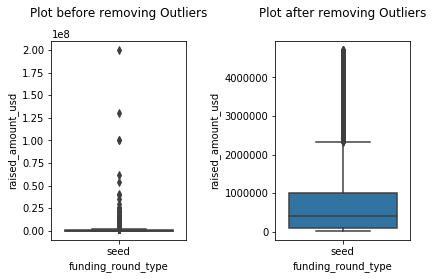

venture :Number of Prominent Outliers above 100000000.0 USD: 523, Total values 50228
venture :Number of Prominent Outliers below 500000.0 USD: 5324, Total values 49705
venture :Average/Median after removing above Prominent Outliers 6000000.0 USD, Total values 44381


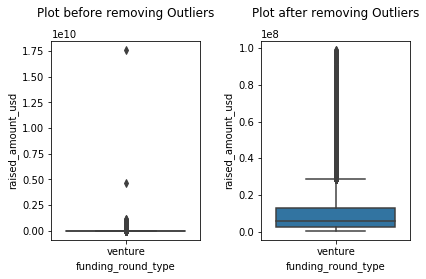

angel :Number of Prominent Outliers above 7000000.0 USD: 52, Total values 4860
angel :Number of Prominent Outliers below 50000.0 USD: 486, Total values 4808
angel :Average/Median after removing above Prominent Outliers 500000.0 USD, Total values 4322


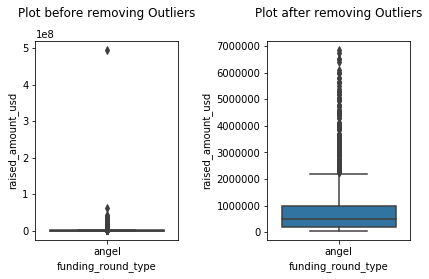

private_equity :Number of Prominent Outliers above 688415689.9000009 USD: 20, Total values 1936
private_equity :Number of Prominent Outliers below 1167500.0 USD: 192, Total values 1916
private_equity :Average/Median after removing above Prominent Outliers 25000000.0 USD, Total values 1724


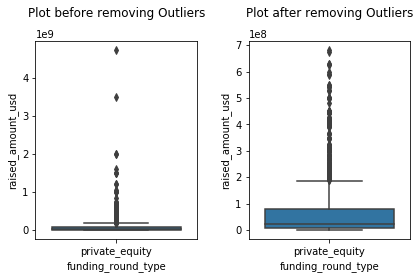

Investment Type suitable for Spark ['venture']
Investment Type mean, fraction tuple: 
[('seed', 400000.0, 1.7159310915431956), ('venture', 6000000.0, 59.6011782486592), ('angel', 500000.0, 0.4705723744353702), ('private_equity', 25000000.0, 14.334091544165753)]


In [701]:
# Remove nan's from raised amount usd column aka received investment funds as the nan values are 17% of total
# data we have chosen to remove them.
master_frame = master_frame[~np.isnan(master_frame["raised_amount_usd"])]

# Below tracks the 5 to 15 Million investment constraint of spark.
spark_funds_constraint = (5000000, 15000000)

def removeProminentOutliersAndCalAvg(type):

    type_df = master_frame[master_frame["funding_round_type"].isin([type])]
    
    # First calculate the total fraction of investment for this type, this is used later for creating plot
    # in checkpoint 6
    frac_investment = 100* (type_df["raised_amount_usd"].sum()/master_frame["raised_amount_usd"].sum())

    # Create a box plot intially showing the prominent scattered outliers, from this graph we have choosen to remove
    # to remove 1% of higher and lower values.
    plt.subplot(121)
    sns.boxplot(x = 'funding_round_type', y = 'raised_amount_usd', data = type_df)
    plt.title("Plot before removing Outliers", y = 1.09)
 

    # Take upper bound as 0.99
    # This would remove very high investments.
    uBound = type_df["raised_amount_usd"].quantile(0.99)
    
    print(type + " :Number of Prominent Outliers above {0} USD: {1}, Total values {2}".\
            format(uBound, type_df[(uBound <= type_df["raised_amount_usd"])]["raised_amount_usd"].count(), \
                    type_df["raised_amount_usd"].count()) )
    
    # Remove the prominent outliers above the uBound range.
    type_df = type_df[(uBound > type_df["raised_amount_usd"])]
    
    # Take lower bound as 0.1.
    # This would help to remove very low including 0 investements.
    lBound = type_df["raised_amount_usd"].quantile(0.1)
 
    print(type + " :Number of Prominent Outliers below {0} USD: {1}, Total values {2}".\
        format(lBound, type_df[(lBound >= type_df["raised_amount_usd"])]["raised_amount_usd"].count(), \
                type_df["raised_amount_usd"].count()) )
    
    # Remove the prominent outliers below the lBound range.
    type_df = type_df[(lBound < type_df["raised_amount_usd"])]
    
    average = type_df["raised_amount_usd"].median()
    print ( type + " :Average/Median after removing above Prominent Outliers {0} USD, Total values {1}"\
           .format(average, type_df["raised_amount_usd"].count()) )

    # Create a box plot after removing the prominent outliers.
    plt.subplot(122)
    sns.boxplot(x = 'funding_round_type', y = 'raised_amount_usd', data = type_df)
    plt.title("Plot after removing Outliers", y = 1.09)
    
    plt.tight_layout()
    plt.show()
    
    return (type, average, frac_investment)

# As per sparks funds constraints below are the investment types we need to pick from.
candidateInvestType = ["seed", "venture", "angel", "private_equity"]


# Since the plotting scale is different for each investment type to different values of investment USD,
# create a box plot to check the prominent scattered outliers for each type independently.
selected_type_list = []
avg_frac_list = []

for type in candidateInvestType:
    type_data = removeProminentOutliersAndCalAvg(type)
    avg_frac_list.append(type_data)
    
    if ((spark_funds_constraint[0] <= type_data[1]) and (type_data[1] <= spark_funds_constraint[1])):
        selected_type_list.append(type_data[0])


print ("Investment Type suitable for Spark {0}".format(selected_type_list))

# This is used while plotting grpahs in Checkpoint 6.
print ("Investment Type mean, fraction tuple: \n{0}".format (avg_frac_list))


## Checkpoint 3
### Check top nine countries which have received the highest total funding across all sectors.
### As we see below top 3 english speaking/official language countries are USA, GBR/UK, IND.

In [702]:
# Filter the data frame so that it contains only the funding type selected in previous checkpoint.
master_frame = master_frame[master_frame["funding_round_type"].isin(selected_type_list)]

# There are mulitple investments received by some countries, group by country code and sum all the investments
# this will give total investment received by the country.
top9 = (master_frame.groupby("country_code")["raised_amount_usd"].sum()).sort_values(ascending = False).head(9)

# Top 3 english speaking country from top9 data frame are as below:
top3Country = ["USA", "GBR", "IND"]

top9


country_code
USA    4.225108e+11
CHN    3.983542e+10
GBR    2.024563e+10
IND    1.439186e+10
CAN    9.583332e+09
FRA    7.259537e+09
ISR    6.907515e+09
DEU    6.346960e+09
JPN    3.363677e+09
Name: raised_amount_usd, dtype: float64

## Checkpoint 4
### Sector Analysis 1: Create primay sector from category list column and map this primary sector to one of the eight main sector present in mapping frame.

In [703]:
mapping = pd.read_csv("mapping.csv", encoding = 'palmos')

# Remove the Blank column which is not valid in mapping frame, also we see 1 Nan value this can also be removed
mapping = mapping[~(mapping["category_list"].isnull())]
mapping.drop(["Blanks"], axis = 1, inplace = True)


# As we noticed that mapping file category list has few unclean categories where '0' is present instead of 'na'. 
# This function replaces such '0's with 'na'.
# Please note that unclean data is such that 0 is present between alphabets if any Ex: ma0gement,
# where it should be management where as Enterprise 2.0 is perfectly fine.
# So three cases are taken where there are alphabets starting with 0 or ending with 0 or
# 0 in between alphabets
def replaceZeroWithNa(categoryValue):
    if ( re.search("(^0[a-zA-z\s])|([a-zA-z\s]0[a-zA-z\s])|([a-zA-z\s]0$)", categoryValue) ):
        return (categoryValue.replace("0", "na"))
    else:
        return categoryValue

mapping["category_list"] = mapping["category_list"].apply (replaceZeroWithNa)

# we see that minimum value of each eight sector is 0 and maximum is 1. There is one Blank and few Nan present.
# Those will get filtered out when we will do inner join with master_frame.
mapping.describe()


,Automotive & Sports,Cleantech / Semiconductors,Entertainment,Health,Manufacturing,"News, Search and Messaging",Others,"Social, Finance, Analytics, Advertising"
count,687.000000,687.000000,687.000000,687.000000,687.000000,687.000000,687.000000,687.000000
mean,0.032023,0.077147,0.129549,0.091703,0.058224,0.104803,0.283843,0.222707
std,0.176190,0.267019,0.336051,0.288817,0.234337,0.306523,0.451190,0.416367
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [704]:
# Apply idmax along the column axis on mapping, this will give us frame with main sector for each
# category/primary sector. Take this frame with interm category list frame and concat them to get desired
# data frame with primay sector mapped to main sector
mapping = pd.concat ([mapping.iloc[:,0], mapping.iloc[:,1:].idxmax(axis = 1)], axis = 1)
mapping.rename (columns = {"category_list" : "primary_sector", 0 : "Main_sector"}, inplace = True)

# remove nan values from category list, then extract the primary sector
master_frame = master_frame[~master_frame["category_list"].isnull()]
master_frame["primary_sector"] = master_frame["category_list"].apply(lambda cat_val: (cat_val).split("|")[0])

# Check for total values in primary sector and see how many are not present in mapping, these will get
# dropped when we will merge(inner join) the two frames on primary sector as we have removed Nan values
# from mapping frame.
# This is to keep track of data dropped in this operation, note it is small in comparison to total data.
notPresent = master_frame[~(master_frame["primary_sector"].isin(mapping["primary_sector"].values))]["primary_sector"].\
                            count()
totalCnt = master_frame["primary_sector"].shape

print ( "Total values of primary sector not present in mapping category {0},\n" \
           "where as total count of primary sector in master frame {1}".format (notPresent, totalCnt))

master_frame = pd.merge(master_frame, mapping, how = 'inner', on = 'primary_sector')




Total values of primary sector not present in mapping category 187,
where as total count of primary sector in master frame (49726,)


## Checkpoint 5
### Sector Analysis 2: Check the most heavily invested main sectors in each of the three countries selected aka USA, GBR/UK, IND and selected funding type/ventures with investments range of 5-15 M USD.


In [705]:
# Since if 15 million upper limit is included in constraint check done at line 12 then there are 
# many companies with highest investment(15 million). So we are saving them in an excel,
# and using it while filling investment.xlsx.
# Please note if we exclude upper limit of 15 million then companies returned are less in number.
# (instead of using head() and giving few having same highest investment) because it gives a bigger picture
# for making investment.
writer = pd.ExcelWriter("companyNames.xlsx")

def getExpectedDataFrame(country_code):
    
    # Get data frames for each selected countries with investment type between 5-15M USD
    D = master_frame[((master_frame["country_code"] == country_code) & 
                            (spark_funds_constraint[0] <= master_frame["raised_amount_usd"]) &
                                    (master_frame["raised_amount_usd"] <= spark_funds_constraint[1]))]
    
    # Group by main sector to calculate sector wise total investement and count/number
    groupByInvest = D.groupby(by = "Main_sector").agg({"raised_amount_usd": "sum", "primary_sector" : "count"}) \
                                    .reset_index()
    
    groupByInvest = groupByInvest.rename(columns = {"raised_amount_usd" : "total_investment", \
                                                    "primary_sector" : "investment_number"})

    # Add total investment and number to D frame, note there will be same values added for rows/company_permalink
    # having same values of main sector.
    D = pd.merge(D, groupByInvest, how = "inner", on = "Main_sector")
    
    print (country_code + " :Total Investment {0} USD, Total Count {1}"\
                 .format (groupByInvest["total_investment"].sum(), groupByInvest["investment_number"].sum()))  
    
    groupByInvest = groupByInvest.sort_values(by = "investment_number", ascending = False).head(3)
    
    print (country_code + " :Top 3 Sector details based upon count \n{0}".format (groupByInvest))
    
    print()
    # While selecting countries make sure that we pick the countries which are not closed.
    topCompanies = D[(D["Main_sector"] == groupByInvest.iloc[0, 0]) & (D["status"] != "closed")]\
                            .sort_values(by = "raised_amount_usd", ascending = False).iloc[:,[6,5,9,16,17,18]]
    
    
    topCompanies.to_excel (writer, country_code + " Top Sector")
    
    print (country_code + " :Company which recieved the highest investment for top sector(Upper 10) {0}\n".\
                       format( topCompanies.iloc[0:10,0:3]))
    
    topCompanies = D[(D["Main_sector"] == groupByInvest.iloc[1, 0]) & (D["status"] != "closed")]\
                            .sort_values(by = "raised_amount_usd", ascending = False).iloc[:,[6,5,9,16,17,18]]
    
    print (country_code + " :Company which recieved the highest investment for second best sector(Upper 10) {0}\n".\
                       format(topCompanies.iloc[0:10,0:3] ))
    
    topCompanies.to_excel (writer, country_code + " Second Top Sector")
    
    
    return D

# D1,D2,D3 are formed inside this function as generic frame D where sector analysis is done for each country.
D1 = getExpectedDataFrame(top3Country[0])
D2 = getExpectedDataFrame(top3Country[1])
D3 = getExpectedDataFrame(top3Country[2])

writer.save()

USA :Total Investment 107318294664.0 USD, Total Count 12012
USA :Top 3 Sector details based upon count 
                               Main_sector  total_investment  \
6                                   Others      2.632101e+10   
7  Social, Finance, Analytics, Advertising      2.380738e+10   
1               Cleantech / Semiconductors      2.120663e+10   

   investment_number  
6               2950  
7               2714  
1               2300  

USA :Company which recieved the highest investment for top sector(Upper 10)                      name  raised_amount_usd     status
10014          Pepperdata         15000000.0  operating
7522               Convio         15000000.0   acquired
9350      Arena Solutions         15000000.0  operating
8180   StreamBase Systems         15000000.0   acquired
9015          Bigcommerce         15000000.0  operating
8598            Incipient         15000000.0  operating
9019              Bluefly         15000000.0        ipo
9348                Ag

## Checkpoint 6
### Create bar plot to display average/mean and fraction of investment for four investment type seed, venture, angel and private equity

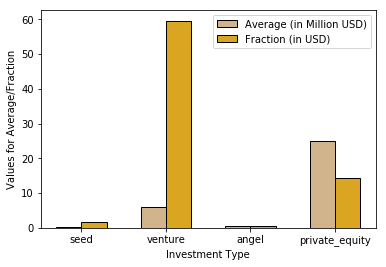

In [706]:
one_million = 1000000

# x-coordinate lables for the bar plot, this points to various investment type
labels = []
# holds the mean for various investment type
mean = []
# hold fraction value for various investment type(globally)
fraction = []
# width of the bars in the plot
barWidth = 0.3

def getDataAndLabels(type_data):
    labels.append(type_data[0])
    mean.append(type_data[1]/one_million)
    fraction.append(type_data[2])

for type_data in avg_frac_list:
    getDataAndLabels(type_data)

# The x position of bars for mean, each number corresponds to an investment type.
r1 = np.arange(len(mean))
# The x position of bars for fraction, for each investment type start from the delta(barWidth)
# from the investment types mean value r1.
r2 = [x + barWidth for x in r1]
 
# Create bars for the mean for various investment type using r1
plt.bar(r1, mean, width = barWidth, color = "tan", edgecolor = "black", capsize=7, label="Average (in Million USD)")
 
# Create bars for fraction for various investment type using r2. This will make sure for each investment type
# both mean and fraction are plotted next to each other.
plt.bar(r2, fraction, width = barWidth, color = "goldenrod", edgecolor = "black", capsize=7, label="Fraction (in USD)")
 
# Tick should be present in between the mean and fraction for an investment type
plt.xticks([r + (barWidth/2) for r in range (len(mean))], labels)

plt.xlabel("Investment Type")
plt.ylabel("Values for Average/Fraction")
plt.legend()
 
plt.show()


### Create bar plot  showing the top 9 countries against the total amount of investments for funding type/venture choosen above.

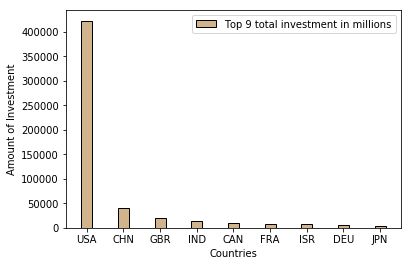

In [707]:
# convert the values of investement in millions
getInMillions = np.vectorize(lambda invest: invest/one_million)

plt.bar(np.arange(top9.index.shape[0]), getInMillions(top9.values), width = barWidth, color = 'tan',\
                    edgecolor = 'black', capsize=7, label='Top 9 total investment in millions')

plt.xticks(np.arange (top9.index.shape[0]), top9.index)
plt.xlabel("Countries")
plt.ylabel("Amount of Investment")
plt.legend()
 
plt.show()


### Create a bar plot showing number of investments in the top 3 sector of the top 3 countries

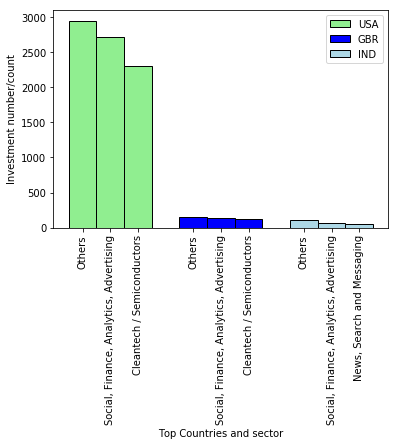

In [708]:

top3Sector = []

top3Sector.append( D1.groupby(by = "Main_sector")["investment_number"].count().reset_index().\
                                 sort_values(by = "investment_number", ascending = False).head(3))

top3Sector.append( D2.groupby(by = "Main_sector")["investment_number"].count().reset_index().\
                                 sort_values(by = "investment_number", ascending = False).head(3))

top3Sector.append( D3.groupby(by = "Main_sector")["investment_number"].count().reset_index().\
                                 sort_values(by = "investment_number", ascending = False).head(3))


barWidth = 0.3
xPos = 0
mainSectorIdx = 0
tickPos = xPos

top3CountryColor = ["lightgreen", "blue", "lightblue"]

for country in top3Country:

    plt.bar([xPos + r for r in np.arange(barWidth,4*barWidth,barWidth)],\
                top3Sector[mainSectorIdx]["investment_number"].values,\
                    width = barWidth, color =  top3CountryColor[top3Country.index(country)], \
                        edgecolor = "black", capsize=7, label = country)

         
    xPos = xPos + 4*barWidth
    mainSectorIdx = mainSectorIdx + 1


sectors = ([ sector for sectorDf in top3Sector for sector in sectorDf["Main_sector"].tolist() ])

xtickspos = list (np.arange(barWidth, 4*barWidth, barWidth))
nextStart = (xtickspos[-1] + barWidth *2)
xtickspos.extend(list (np.arange(nextStart, nextStart + 3*barWidth, barWidth) ))
nextStart = (xtickspos[-1] + barWidth *2)
xtickspos.extend(list (np.arange(nextStart, nextStart + 2*barWidth, barWidth) ))

plt.xticks( xtickspos, sectors, rotation = "vertical")

plt.xlabel("Top Countries and sector")
plt.ylabel("Investment number/count")
plt.legend()
 
plt.show()